<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Graphs4Sci/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"><h1>Visualization for Science</h1>
<h1>Airline Traffic Between States</h1>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

from tqdm import tqdm
tqdm.pandas()
import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: b0df0744a9ceb2dc3278e596daa1577a69f9ac99

watermark : 2.5.0
tqdm      : 4.67.1
matplotlib: 3.10.1
pandas    : 2.2.3
numpy     : 2.2.4



Set the default list of colors

In [3]:
colors = [
 '#51a7f9',
 '#cf51f9',
 '#70bf41',
 '#f39019',
 '#f9e351',
 '#f9517b',
 '#6d904f',
 '#8b8b8b',
 '#810f7c',
]

# Airport Data

As [before](https://data4sci.substack.com/p/graphs-101), we load the data from the "T-100 Domestic Segment (U.S. Carriers)" file covering the entire year of 2019 that we downloaded from [BTS](https://www.transtats.bts.gov/Tables.asp?DB_ID=110&DB_Name=Air%20Carrier%20Statistics%20(Form%2041%20Traffic)-%20%20U.S.%20Carriers). The online database allows you to select many fields, but we'll use just a few.

In [4]:
flights = pd.read_csv('https://github.com/DataForScience/Graphs4Sci/raw/master/data/336781026_T_T100D_SEGMENT_US_CARRIER_ONLY.zip',
                     usecols=['ORIGIN_STATE_ABR', 'DEST_STATE_ABR', 'PASSENGERS'],
                     dtype={'ORIGIN':'str', 'DEST': 'str', 'PASSENGERS':'int'})

We're interested in total number of passengers flying from one state to the next, so we aggregate by state

In [5]:
totals = flights.groupby(['ORIGIN_STATE_ABR', 'DEST_STATE_ABR'], as_index=False).sum()

Remove self loops (flights within the state)

In [6]:
totals = totals[totals.ORIGIN_STATE_ABR != totals.DEST_STATE_ABR].copy()

And remove non-state territories

In [7]:
exclude_territories = ['PR', 'TT', 'VI']

totals = totals[
    (~totals.ORIGIN_STATE_ABR.isin(exclude_territories)) & 
    (~totals.DEST_STATE_ABR.isin(exclude_territories))
    ].copy()

Now the `totals` DataFrame has the total number of passengers flying from one state (`ORIGIN_STATE_ABR`) to another (`DEST_STATE_ABR`). These are too many connections to visualize, so we write a function to extract only the Top N destinations:

In [8]:
def TopDestinations(x, n=5):
    """
        Extract the Top N destinations for a given origin. 
        The last row will contain the sum of the remaining destinations, 
        and the values are normlized by the total number of passengers.
    """
    output = x.sort_values('PASSENGERS', ascending=False).iloc[:(n+1)]
    other = x.sort_values('PASSENGERS', ascending=False).iloc[n:]['PASSENGERS'].sum()
    total = x.PASSENGERS.sum()

    output.loc[output.index[-1], "DEST_STATE_ABR"]="Other"
    output.loc[output.index[-1], "PASSENGERS"] = other

    output.PASSENGERS/=total

    return output

Now we apply this function to every origin state to get the Top 5 connections by origin

In [9]:
totals = totals.groupby('ORIGIN_STATE_ABR', as_index=False).apply(TopDestinations, n=5)

Our function works as expected, as we can see by subsetting to a specific origin state

In [10]:
totals[totals.ORIGIN_STATE_ABR == 'NY']

ORIGIN_STATE_ABR DEST_STATE_ABR  PASSENGERS
33 1401               NY             FL    0.230190
   1397               NY             CA    0.101503
   1406               NY             IL    0.089831
   1402               NY             GA    0.076296
   1419               NY             NC    0.062543
   1436               NY          Other    0.439638

Before we can visualize the connections between states, we need to have locations for each state. We load the same locations we used [before](https://data4sci.substack.com/p/time-series-state-map)

In [11]:
states = pd.read_csv('https://raw.githubusercontent.com/DataForScience/Epidemiology101/master/data/states.csv', index_col=0)
# DC doesn't have any airports, so we don't plot it
states.drop(index='DC', inplace=True)

Unfortunately, matplotlib's `pie` function doesn't allow us to plot multiple pie plots in the same `Axes` object, so we write our own pie plot function using the [Wedge](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Wedge.html) patch.

In [12]:
def pie_location(x, y, r, values, ax):
    angles = values.cumsum() / values.sum() * 360
    labels = values.index

    wedges = []
    r0 = r + 0.1
    for i in range(angles.shape[0]):
        if i == 0:
            angle0 = 0
        else:
            angle0 = angles.values[i-1]
        
        angle1 = angles.values[i]
        angle2 = (angle0 + angle1) / 2

        x0 = x + r0 * np.cos(np.deg2rad(angle2))
        y0 = y + r0 * np.sin(np.deg2rad(angle2))

        ax.text(
                x0, 
                y0, 
                labels[i], 
                ha='center', 
                va='center',
                fontsize=8, 
                color=colors[i if i<4 else i+2],
                )

        wedge = mpatches.Wedge(center=(x, y), 
                               r=r, 
                               theta1=angle0, 
                               theta2=angle1, 
                               facecolor=colors[i if i<4 else i+2], 
                               edgecolor=None)
        wedges.append(wedge)


    # Add the Wedge to the plot
    ax.add_collection(PatchCollection(wedges, match_original=True))


Using this function we can plot a pie chart at any point `(x, y)`:

In [13]:
?ax.grid

Object `ax.grid` not found.


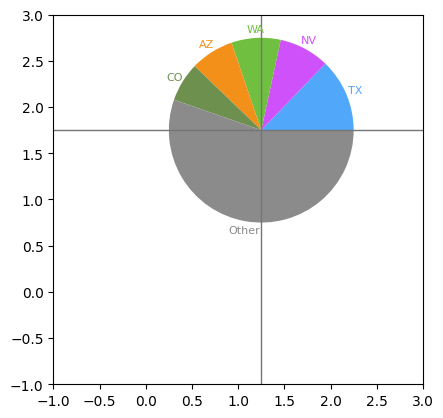

In [14]:
fig, ax = plt.subplots(1)
ax.set_xlim(-1, 3)
ax.set_ylim(-1, 3)
ax.set_aspect(1.)

pie_location(x=1.25, 
             y=1.75, 
             r=1, 
             values=totals[totals.ORIGIN_STATE_ABR == 'CA'].set_index('DEST_STATE_ABR')['PASSENGERS'], 
             ax=ax)

# Add guide lines to show that the pie is centered at (1.25, 1.75)
ax.axvline(x=1.25, color='#757575', lw=1)
ax.axhline(y=1.75, color='#757575', lw=1)

Now we are ready to plot the pie charts for each state in their proper locations

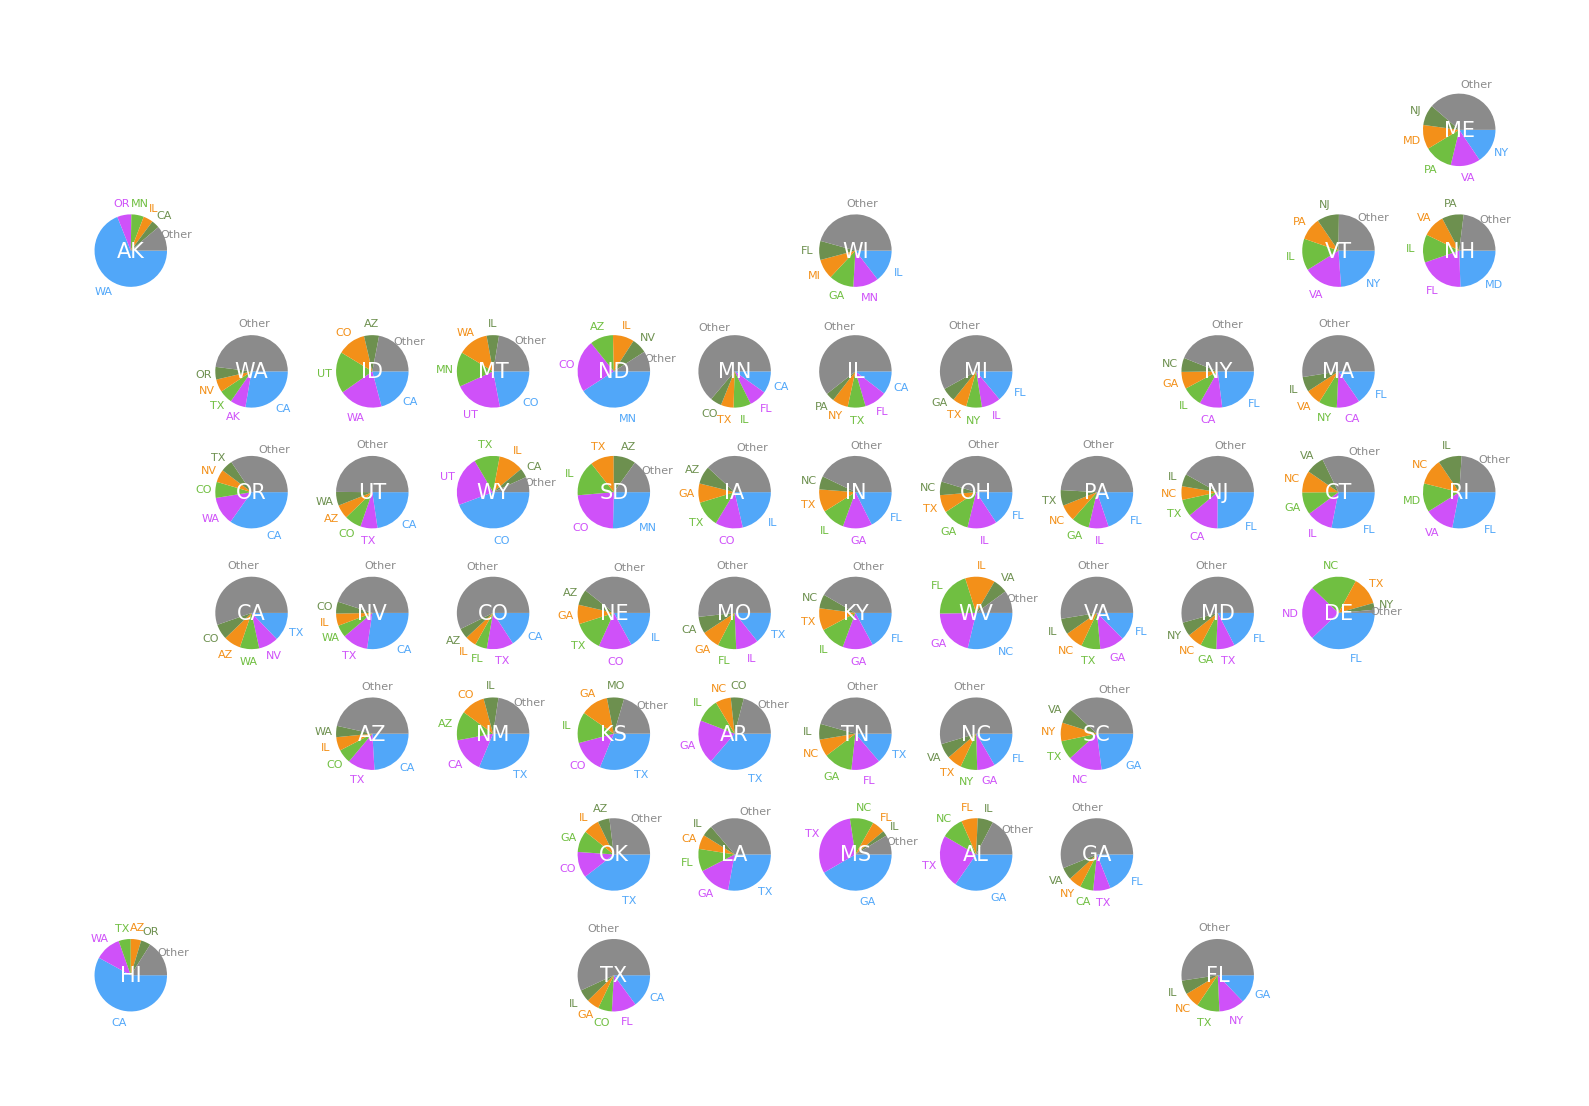

In [15]:
fig, ax = plt.subplots(1, figsize=(16, 22))
ax.set_aspect(1.)
ax.invert_yaxis()

patches = []

for state in states.index:
    color = colors[3]
    
    fancybox = mpatches.FancyBboxPatch([states.x[state]-0.5, 
                                        states.y[state]-0.5], 0.8, 0.8,
                                        boxstyle=mpatches.BoxStyle("Round", 
                                                                   pad=0.06))
    patches.append(fancybox)
    
    ax.text(y=states.y[state], x=states.x[state], 
            s=state, ha='center', va='center', fontsize=15, color='white')
    
    pie_location(states.x[state], states.y[state], 0.3,
                 totals[totals.ORIGIN_STATE_ABR == state].set_index('DEST_STATE_ABR')['PASSENGERS'],
                 ax=ax)

ax.set_xlim(-1, 12)
ax.set_ylim(8, -1)
ax.axis('off')
fig.tight_layout()

We can also add edges connecting the Top destinations, but that makes the plot a bit messier

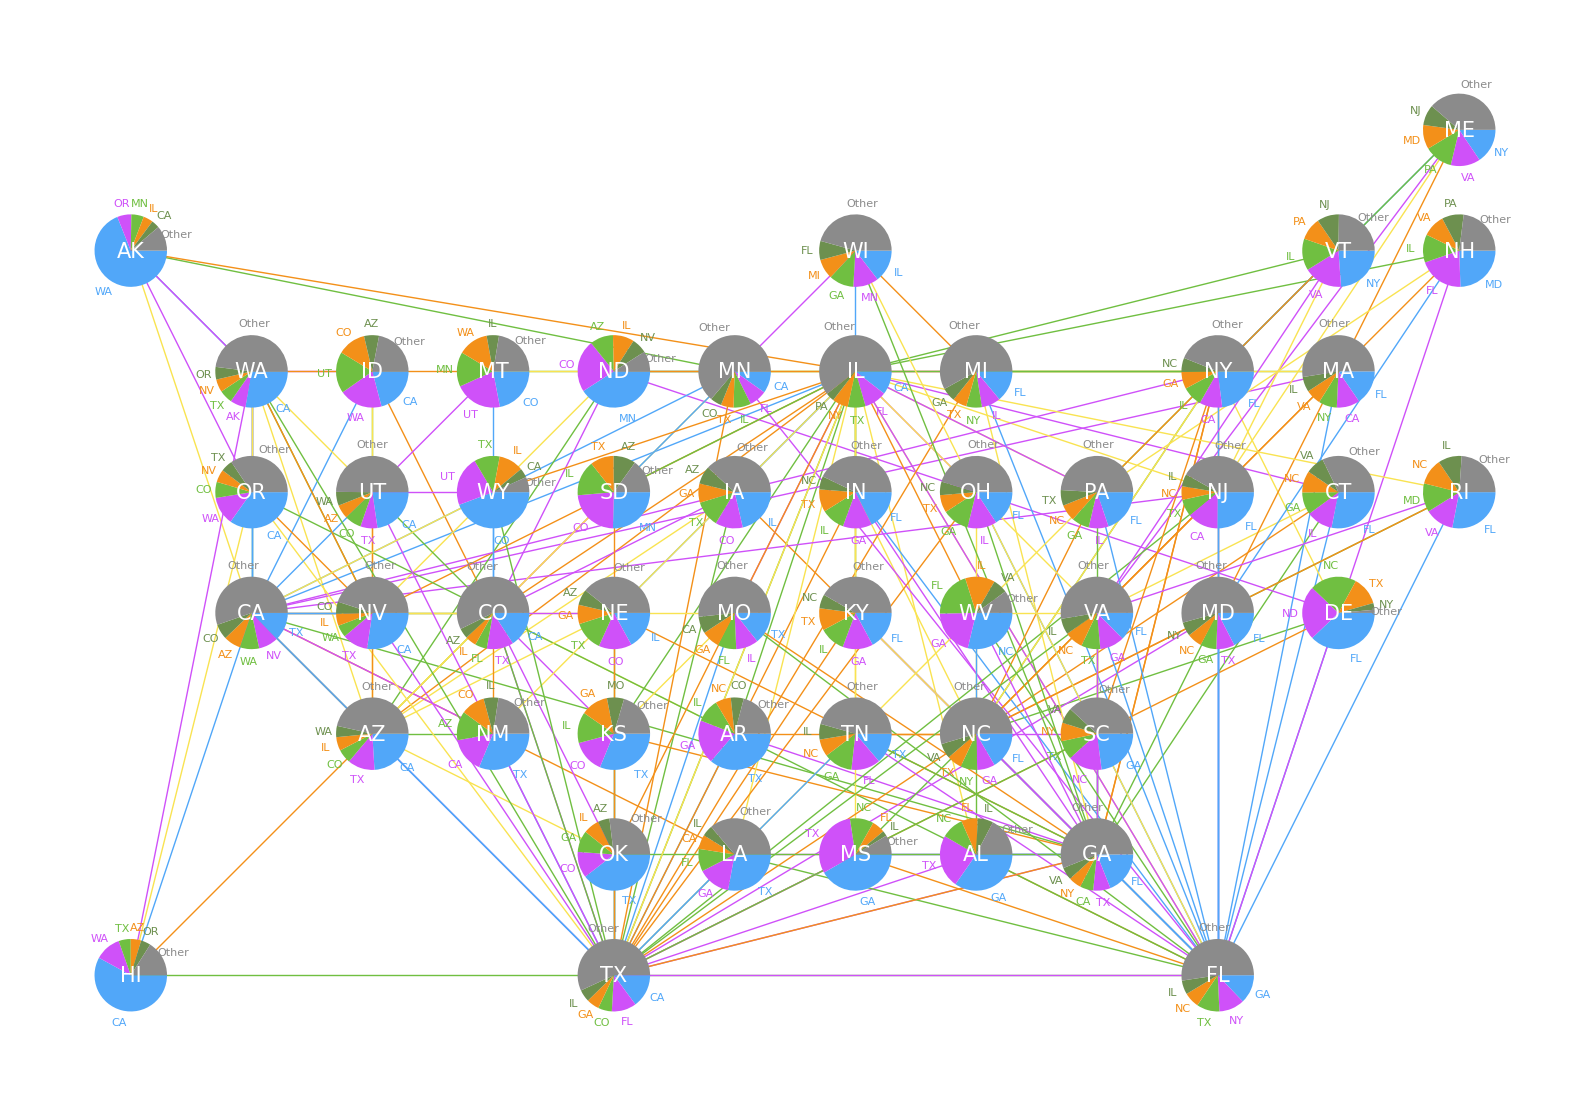

In [16]:
fig, ax = plt.subplots(1, figsize=(16, 22))
ax.set_aspect(1.)
ax.invert_yaxis()

patches = []

for state in states.index:
    color = colors[3]
    
    fancybox = mpatches.FancyBboxPatch([states.x[state]-0.5, 
                                        states.y[state]-0.5], 0.8, 0.8,
                                        boxstyle=mpatches.BoxStyle("Round", 
                                                                   pad=0.06))
    patches.append(fancybox)
    
    ax.text(y=states.y[state], x=states.x[state], 
            s=state, ha='center', va='center', fontsize=15, color='white')
    
    pie_location(states.x[state], states.y[state], 0.3,
                 totals[totals.ORIGIN_STATE_ABR == state].set_index('DEST_STATE_ABR')['PASSENGERS'],
                 ax=ax)

pos = 0
old_state = None

for row in totals.itertuples():
    if row.ORIGIN_STATE_ABR != old_state:
        pos = 0
        old_state = row.ORIGIN_STATE_ABR
    else:
        pos += 1

    if row.ORIGIN_STATE_ABR == 'Other' or row.DEST_STATE_ABR == 'Other':
        continue
    
    x0, y0 = states.loc[row.ORIGIN_STATE_ABR][['x', 'y']]
    x1, y1 = states.loc[row.DEST_STATE_ABR][['x', 'y']]

    ax.plot([x0, x1], [y0, y1], color=colors[pos], linewidth=1, zorder=-1)

ax.set_xlim(-1, 12)
ax.set_ylim(8, -1)
ax.axis('off')
fig.tight_layout()

<center>
     <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>